In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score
from sklearn.feature_selection import mutual_info_regression

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

import pytz
import shap
import pickle

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

RANDOM_STATE = 42

# Perameters


In [2]:
node_id = '10004098'
dir_out = '../figures/spatial/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1))#.astype(str)
#for i in range(len(wavelengths)):
#    wavelengths[i] = wavelengths[i] + 'nm'
#wavelengths = list(wavelengths)

# Read Data

In [3]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + 'driving_' + node_id + '_NEXRAD_5km_landsat.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')

# iwant = df.index.date < datetime.date(2020, 3, 1)
# df = df[iwant]

surface_reflectances_rename =  {'Surface Reflectance Band 1' : 'Surface Reflectance 435-451 nm', # 435-451nm, Ultra Blue
                                'Surface Reflectance Band 2' : 'Surface Reflectance 452-512 nm', # 452-512nm, Blue
                                'Surface Reflectance Band 3' : 'Surface Reflectance 533-590 nm', # 533-590nm, Greeen
                                'Surface Reflectance Band 4' : 'Surface Reflectance 636-673 nm'} # 636-673nm, Readm

surface_reflectances = ['Surface Reflectance 435-451 nm', # 435-451nm, Ultra Blue
                        'Surface Reflectance 452-512 nm', # 452-512nm, Blue
                        'Surface Reflectance 533-590 nm', # 533-590nm, Greeen
                        'Surface Reflectance 636-673 nm'] # 636-673nm, Red

df = df.rename(columns=surface_reflectances_rename)
df.head()

,Illuminance,360nm,361nm,362nm,363nm,364nm,365nm,366nm,367nm,368nm,...,Reflectivity Level_10km South_5km,Reflectivity Level_10km South_5km West_5km,Reflectivity Level_10km West_5km,Reflectivity Level_10km North_5km West_5km,LocalTime,date,Surface Reflectance 435-451 nm,Surface Reflectance 452-512 nm,Surface Reflectance 533-590 nm,Surface Reflectance 636-673 nm
UTC,,,,,,,,,,,,,,,,,,,,,
2020-01-08 16:43:50,2345.220551,0.032529,0.032651,0.033183,0.033997,0.034946,0.035627,0.036239,0.036761,0.037158,...,NaN,NaN,NaN,NaN,2020-01-08 10:43:50,2020/01/08,582,656,925,1029
2020-01-08 16:44:00,2385.540894,0.033112,0.033226,0.033758,0.034580,0.035541,0.036231,0.036851,0.037380,0.037782,...,NaN,NaN,NaN,NaN,2020-01-08 10:44:00,2020/01/08,974,1096,1371,1635
2020-01-08 16:46:40,3521.045288,0.036604,0.036802,0.037441,0.038386,0.039475,0.040252,0.040949,0.041550,0.042018,...,NaN,NaN,NaN,NaN,2020-01-08 10:46:40,2020/01/08,907,1043,1421,1676
2020-01-08 16:46:50,4220.051209,0.044110,0.044308,0.045068,0.046215,0.047553,0.048541,0.049440,0.050220,0.050827,...,NaN,NaN,NaN,NaN,2020-01-08 10:46:50,2020/01/08,1042,1167,1566,1761
2020-01-08 16:47:00,4105.486389,0.043972,0.044196,0.044981,0.046150,0.047503,0.048477,0.049356,0.050115,0.050708,...,NaN,NaN,NaN,NaN,2020-01-08 10:47:00,2020/01/08,841,925,1185,1359


In [4]:
# grid parameters
step = 100 # grid resolution (meter) in x-y plane

z_0, delta_z = 0, 10000
num_z = int(delta_z // 1000) + 1

delta_y , delta_x  = 1000, 1000 # neighbor distance
delta_iy, delta_ix = int(delta_y / step), int(delta_x / step)

# neighbor parameters
neighbor = {'': (0, 0)}
km_max = 5
for i in range(1,km_max+1): # distance (km)
    neighbor['North_%dkm'          %(i  )] = ( i*delta_iy,           0)
    neighbor['North_%dkm East_%dkm'%(i,i)] = ( i*delta_iy,  i*delta_ix)
    neighbor[           'East_%dkm'%(  i)] = (          0,  i*delta_ix)
    neighbor['South_%dkm East_%dkm'%(i,i)] = (-i*delta_iy,  i*delta_ix)
    neighbor['South_%dkm'          %(i  )] = (-i*delta_iy,           0)
    neighbor['South_%dkm West_%dkm'%(i,i)] = (-i*delta_iy, -i*delta_ix)
    neighbor[           'West_%dkm'%(  i)] = (          0, -i*delta_ix)
    neighbor['North_%dkm West_%dkm'%(i,i)] = ( i*delta_iy, -i*delta_ix)
    

In [6]:
features0 = ['altitude', 'Zenith', 'Azimuth', 'Sun Distance']
# features0 = ['Zenith', 'Sun Distance']

features = features0.copy()
reflectivities = []
for iz in range(num_z):
    for direction in neighbor:
        var = 'Reflectivity Level_%dkm' % (iz)
        if direction:
            var += ' ' + direction
        reflectivities.append(var)

# features += reflectivities

features += surface_reflectances
features = np.array(features)

num_features = len(features)
print(num_features)

wavelengths = np.array(range(360,780+1))#.astype(str)
targets =np.array([str(wavelength) + 'nm' for wavelength in wavelengths]) # skip Illuminance, keep Wavelengths
# targets = ['Illuminance']


8


In [6]:
# try to apply exp on the reflectivities
# since L_Z=10 log10(Z/Z_0) in dbz
# so (Z/Z_0) = 10^(L_z/10)
# df[reflectivities] = (10**(df[reflectivities]/10)).fillna(0)

In [7]:
# cut off the brightness of night or when the sensor is covered
iwant = (df['Illuminance'] > 1000) #& (df.index.date < datetime.date(2020, 4, 1))

In [8]:
X = df[features][iwant]
Y = df[targets][iwant] # model and scaler use multi output

In [9]:
X_train_all, X_test, Y_train_all, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_all, Y_train_all, test_size=0.2, random_state=0)

In [10]:
# scale the output
scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_valid_scaled = scaler_y.transform(Y_valid)
Y_test_scaled = scaler_y.transform(Y_test)


In [11]:
# PCA to the scaled output

n_components = 3

DR = 'PCA'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)

Y_train_scaled_DR = pca.fit_transform(Y_train_scaled)
Y_valid_scaled_DR = pca.transform(Y_valid_scaled)
Y_test_scaled_DR = pca.transform(Y_test_scaled)

Y_train_scaled_DR = pd.DataFrame(Y_train_scaled_DR, index = Y_train.index)
Y_valid_scaled_DR = pd.DataFrame(Y_valid_scaled_DR, index = Y_valid.index)
Y_test_scaled_DR = pd.DataFrame(Y_test_scaled_DR, index = Y_test.index)

print(pca.explained_variance_)

[4.13678829e+02 7.00593283e+00 1.99329190e-01]


# Model Trainning

In [13]:
import lightgbm as lgb
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
DR = ''

In [324]:
rs_cv.best_params_

{'subsample': 0.5,
 'silent': True,
 'reg_lambda': 50,
 'reg_alpha': 5,
 'random_state': 42,
 'objective': 'regression',
 'num_leaves': 113,
 'n_estimators': 110,
 'max_depth': -1,
 'learning_rate': 0.2,
 'colsample_bytree': 0.5}

In [14]:
# Fit the Model with Optimized Hyper-Parameters
# param = {
#     'num_leaves': 128, # default = 31, Maximum tree leaves for base learners
#     'max_depth' : -1, # default = -1, Maximum tree depth for base learners
#     'learning_rate': 0.05, # default = 0.1
#     'n_estimators': 140, # default = 100, Number of boosted trees
# #     'subsample_for_bin': 200000, # default = 200000
#     'objective' : 'regression', # ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier
# #     'class_weight': 'balanced', # default = None, for multi-class
# #     'min_child_weight' : 100., # default=1e-3
# #     'min_child_samples': 467, # default=20
#     'subsample': 1.0, # default=1.
#     'colsample_bytree': 0.9, # default=1.
#     'reg_alpha': 50, # default=0.  L1 regularization
#     'reg_lambda': 0, # default=0.  L2 regularization
#     'random_state' : RANDOM_STATE, # default=None
#     'silent': True, # default=True
# }

param = {
'subsample': 0.5,
'silent': True,
'reg_lambda': 50,
'reg_alpha': 5,
'random_state': 42,
'objective': 'regression',
'num_leaves': 113,
'n_estimators': 110,
'max_depth': -1,
'learning_rate': 0.2,
'colsample_bytree': 0.5
}

# structure   = '_' + DR + str(n_components) \
structure   = '_' + 'ne' + str(param['n_estimators'])\
            + '_' + 'de' + str(param['max_depth'])\
            + '_' + 'nl' + str(param['num_leaves'])\
            + '_' + 'sr' + str(param['subsample'])\
            + '_' + 'fr' + str(param['colsample_bytree'])\
            + '_' + 'l1_' + str(param['reg_alpha'])\
            + '_' + 'l2_' + str(param['reg_lambda'])\


model_base = lgb.LGBMRegressor(**param)
model = MultiOutputRegressor(model_base)

fit_params = {"early_stopping_rounds":30, 
              "eval_metric": 'mse', # l2 is mean_squared_error
              "eval_set": [(X_valid, Y_valid_scaled_DR)],
              'eval_names': ['valid'],
              'verbose': 100,
              'categorical_feature': 'auto', # default='auto'
             }

warnings.filterwarnings("ignore")
# model.fit(X_train_scaled_DR_scaled, Y_train_scaled)#, **fit_params)
model.fit(X_train, Y_train_scaled_DR)#, **fit_params)

MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=0.5,
                                             learning_rate=0.2,
                                             n_estimators=110, num_leaves=113,
                                             objective='regression',
                                             random_state=42, reg_alpha=5,
                                             reg_lambda=50, subsample=0.5))

In [16]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_test, Y_test_pred)

0.0005523122950621594

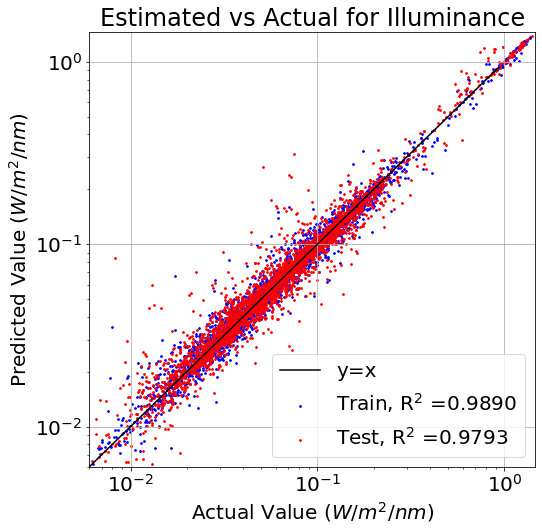

In [15]:
from sklearn.metrics import r2_score

# train
Y_train_pred = scaler_y.inverse_transform(pca.inverse_transform(model.predict(X_train)))#[reflectivities_DR] )
train_score = r2_score(Y_train, Y_train_pred)

# test
Y_test_pred = scaler_y.inverse_transform(pca.inverse_transform(model.predict(X_test)))#[reflectivities_DR] )
test_score = r2_score(Y_test, Y_test_pred)

# flatten
Y_train_flatten = Y_train.values.flatten()
Y_train_pred_flatten = Y_train_pred.flatten()

Y_test_flatten = Y_test.values.flatten()
Y_test_pred_flatten = Y_test_pred.flatten()

Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)

y_line = np.linspace(Y_min,Y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten), 3000, replace = False)
plt.scatter(Y_train_flatten[id_train], Y_train_pred_flatten[id_train], s=3, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])

id_test = np.random.choice(len(Y_test_flatten), 3000, replace = False)
plt.scatter(Y_test_flatten[id_test], Y_test_pred_flatten[id_test], s=3, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])

plt.xlim(6E-3, )
plt.ylim(6E-3, )

ax.set_title('Estimated vs Actual for Illuminance')# Spectrum')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Predicted Value $(W/m^2/nm)$')
plt.xscale('log')
plt.yscale('log')
plt.legend( loc='lower right')
plt.grid()
# plt.tight_layout()

if not os.path.exists(dir_out + 'Illuminance'):
    os.mkdir(dir_out + 'Illuminance')
# plt.savefig(dir_out + 'Illuminance' +'/MLP_performance_whole'+structure+'.png')



In [130]:
Y_train_flatten_sorted = np.sort(Y_train_flatten)
Y_train_pred_flatten_sorted = np.sort(Y_train_pred_flatten)

Y_test_flatten_sorted = np.sort(Y_test_flatten)
Y_test_pred_flatten_sorted = np.sort(Y_test_pred_flatten)

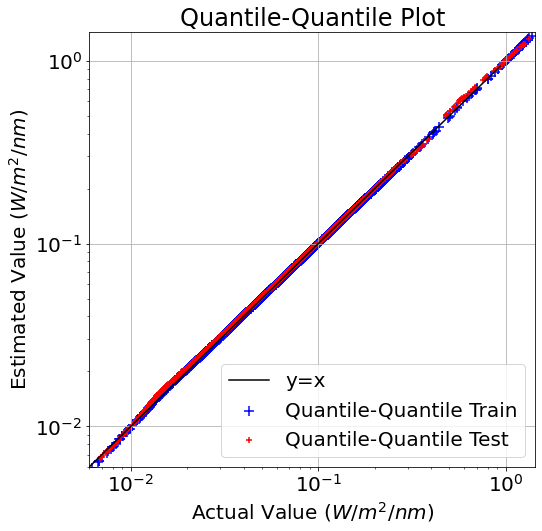

In [131]:
Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)
y_line = np.linspace(Y_min,Y_max,100)
# 

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten_sorted), 2000, replace = False)
plt.scatter(Y_train_flatten_sorted[id_train], Y_train_pred_flatten_sorted[id_train], s=100, c = 'blue',
            marker = '+', label = 'Quantile-Quantile Train')

id_test = np.random.choice(len(Y_test_flatten_sorted), 2000, replace = False)
plt.scatter(Y_test_flatten_sorted[id_test], Y_test_pred_flatten_sorted[id_test], s=30, c = 'red',
            marker = '+', label = 'Quantile-Quantile Test')
plt.xlim(6E-3, )
plt.ylim(6E-3, )

# x_25 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//4]
# y_25 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//4]
# x_50 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//2]
# y_50 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//2]
# x_75 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//4*3]
# y_75 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//4*3]
# plt.text(x_25, y_25, '25', c ='blue', ha = 'center', va = 'center')
# plt.text(x_50, y_50, '50', c ='blue', ha = 'center', va = 'center')
# plt.text(x_75, y_75, '75', c ='blue', ha = 'center', va = 'center')

ax.set_title('Quantile-Quantile Plot')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Estimated Value $(W/m^2/nm)$')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend( loc='lower right')

# plt.tight_layout()

if not os.path.exists(dir_out + 'whole'):
    os.mkdir(dir_out + 'whole')
# plt.savefig(dir_out + 'whole' +'/MLP_QQ_whole'+structure+'.png')


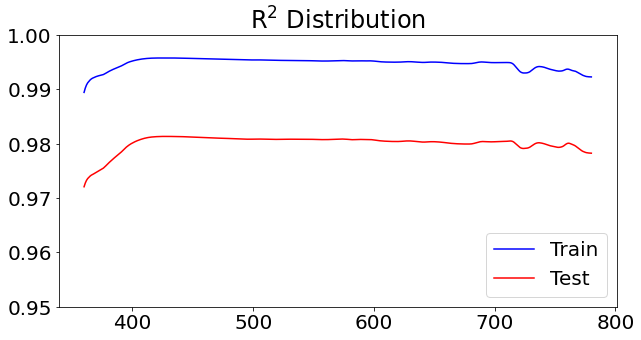

In [132]:
train_scores = []
test_scores = []
for i in range(len(wavelengths)):
    train_scores.append( r2_score(Y_train.iloc[:,i], Y_train_pred[:,i]) )
    test_scores.append( r2_score(Y_test.iloc[:,i], Y_test_pred[:,i]) )

plt.rcParams["figure.figsize"] = (10, 5) # (w, h)
plt.plot(np.array(range(360,780+1)),train_scores, 'b', label = 'Train')
plt.plot(np.array(range(360,780+1)),test_scores, 'r', label = 'Test')
plt.ylim(0.95,1)
plt.title("R$^2$ Distribution")
plt.legend( loc='lower right')
# plt.savefig(dir_out + 'whole' + '/MLP_R2' + structure + '.png')


In [17]:
# Create object that can calculate shap values
num_shap = 500
start_time = time.time()
explainer0 = shap.TreeExplainer(model.estimators_[0])
tree_shap_values0 = explainer0.shap_values(X_train[:num_shap]) # 421 x num_shap x n_components

explainer1 = shap.TreeExplainer(model.estimators_[1])
tree_shap_values1 = explainer1.shap_values(X_train[:num_shap]) # 421 x num_shap x n_components

explainer2 = shap.TreeExplainer(model.estimators_[2])
tree_shap_values2 = explainer2.shap_values(X_train[:num_shap]) # 421 x num_shap x n_components


print("--- %s seconds ---" % (time.time() - start_time))

--- 1.788620948791504 seconds ---


In [18]:
tree_shap_values_Xmulti_Yscaled = tree_shap_values0[:,:,None]*pca.components_[0][None,:] \
                                + tree_shap_values1[:,:,None]*pca.components_[1][None,:] \
                                + tree_shap_values2[:,:,None]*pca.components_[2][None,:]

# scaled SHAP values averaged on different wavelengths
tree_shap_values_Yscaled = np.mean(tree_shap_values_Xmulti_Yscaled, axis = -1)

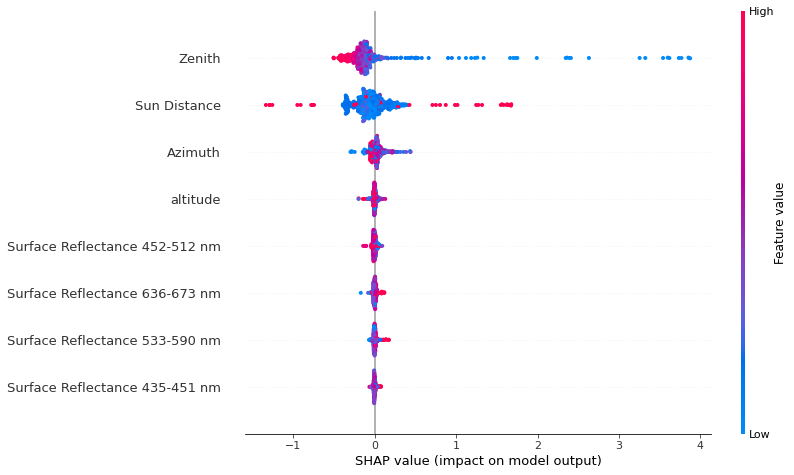

In [19]:
# plot
max_display = 15
# shap_values = pca.inverse_transform(shap_values_DR)
shap.summary_plot(tree_shap_values_Yscaled, X_train[:num_shap],
#                   feature_names = features_DR,
                  plot_size=(12,int(max_display/2)),#'auto'
                  max_display = max_display,
                  show=False
                 )
# plt.xlim(-20000, 30000)
plt.tight_layout()
# plt.savefig(dir_out + 'Illuminance' + '/MLP_shapPCA_'+ 'Illuminance' +structure+'.png')

In [194]:
# importances of sun direction/distance and altitude
print(features0)
importances[:4]

['altitude', 'Zenith', 'Azimuth', 'Sun Distance']


NameError: name 'importances' is not defined

In [288]:
# sum of importances of NEXRAD reflectivities
importances[4:4+len(reflectivities)].sum()

4404.782762260504

In [289]:
# sum of importances of landsat surface reflectance
importances[-len(surface_reflectances):].sum()

413.9648397430624

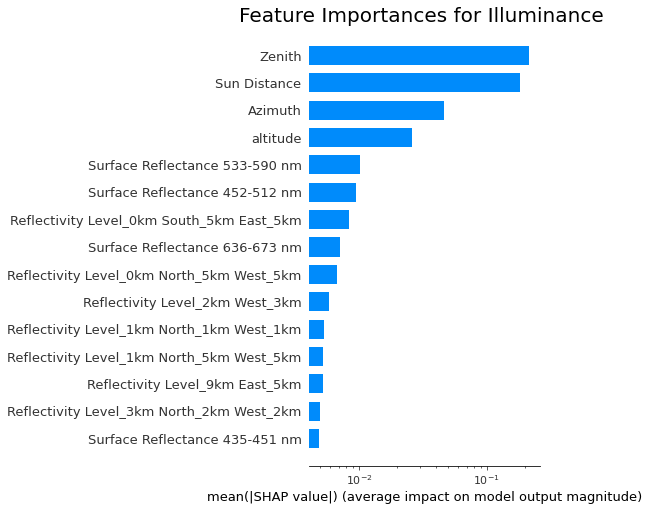

In [200]:
importances = np.mean(np.abs(tree_shap_values_Yscaled), axis = 0)
indices = np.argsort(importances)

# color positive/negative impact blue/red
# colormap = {1:'red',-1:'blue', 0:'grey'}
# impacts = np.array([])
# corrcoef = np.array([])
# sign = np.array([])
# for i in range(n_components):
#     impact_i = (shap_values_DR[:,i]*np.sign(X_train_scaled_DR_scaled[:num_shap,i] - X_train_scaled_DR_scaled[:num_shap, i].mean() )).mean()
#     impacts = np.append(impacts, impact_i)

#     corrcoef_i = np.corrcoef(X_train_scaled_DR_scaled[:,i], Y_train_pred.mean(axis = 1))[0,1]
#     corrcoef = np.append(corrcoef, corrcoef_i)
    
#     sign_i = np.sign(corrcoef_i)
#     sign = np.append(sign, sign_i)

# sign = sign[indices]
# impacts = impacts[indices]
# corrcoef = corrcoef[indices]

# # norm = mpl.colors.SymLogNorm(10, vmin=0, vmax=+0.05)
# norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
# cmap = cm.get_cmap('RdBu_r')
# m = cm.ScalarMappable(norm=norm, cmap=cmap)

# color = [colormap[val] for val in sign]
# # color = [m.to_rgba(val) for val in impacts]
# # color = [m.to_rgba(val) for val in corrcoef]

shap.summary_plot(tree_shap_values_Yscaled, X_train[:num_shap],
                  feature_names = features,
                  plot_size=(8,max_display/2),#'auto'
#                   color = color,
                  max_display = max_display,
                  show = False,
                  plot_type = 'bar'
                 )

plt.xscale("log")
plt.title('Feature Importances for Illuminance ', fontsize = 20)
plt.tight_layout()
# plt.savefig(dir_out + 'Illuminance' + '/MLP_'+'Importances_' + 'Illuminance' + structure +'.png')


In [493]:
print(features0)
importances[:4]

['altitude', 'Zenith', 'Azimuth', 'Sun Distance']


array([ 510.00930234, 4665.4367973 ,  595.53280061, 1715.65415173])

In [496]:
# total importances of reflctivities
importances[4:].sum()

2797.050749972459